In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Based off of generalized stats

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
# from scipy.stats import norm

def convertTOItoSec (x):
  mins, secs = map(int, x.split(':'))
  return (mins + secs/60)/60

def objective_function(weights, league_data, percentile_target):
    """
    Objective function to minimize the squared error between the desired
    percentile Game Score and 1.00.
    """
    game_scores = league_data @ weights  # Compute Game Scores
    percentile_value = np.percentile(game_scores, percentile_target)  # Target percentile value
    return (percentile_value - 1.0) ** 2  # Minimize squared error from target


def optimize_weights(df, metrics, percentile_target, initial_weights, bounds, constraints):
    """
    Optimizes weights for Game Score calculation.
    """
    # Extract relevant data
    league_data = df[metrics].values
    # Normalize league data using min-max scaling
    # league_data_normalized = (league_data - league_data.min(axis=0)) / (league_data.max(axis=0) - league_data.min(axis=0))

    # Perform optimization
    result = minimize(
        objective_function,
        initial_weights,
        args=(league_data, percentile_target),
        bounds=bounds,
        constraints=constraints
    )

    return result.x  # Optimized weights


def calculate_game_score(
    df: pd.DataFrame,
    metrics: list,
    percentile_target: float,
    initial_weights: dict = None
) -> (pd.DataFrame, pd.DataFrame):
    """
    Calculate Game Scores for hockey players based on metrics and adjust scores
    to align the target percentile with a defined value.

    Parameters:
    - df: pd.DataFrame
        A cleaned DataFrame containing player-game performance metrics.
    - metrics: list
        A list of column names in the DataFrame representing the metrics used for Game Score.
    - percentile_target: float
        The percentile (e.g., 75.0 or 99.999) that should align with the scaled Game Score of 1.00.
    - initial_weights: dict (optional)
        Predefined weights for specific metrics. If None, all metrics start with equal weighting.

    Returns:
    - pd.DataFrame:
        DataFrame with added columns for non-adjusted and adjusted Game Scores.
    - pd.DataFrame:
        DataFrame containing the optimized weights for each metric.
    """

    # Step 1: Set initial weights
    if initial_weights:
        # Use user-provided weights, and distribute remaining weight equally
        remaining_metrics = [metric for metric in metrics if metric not in initial_weights]
        remaining_weight = 1.0 - sum(initial_weights.values())
        weights_dict = {
            **initial_weights,
            **{metric: remaining_weight / len(remaining_metrics) for metric in remaining_metrics}
        }
    else:
        # Default to equal weighting
        weights_dict = {metric: 1 / len(metrics) for metric in metrics}

    # Convert weights to array for optimization
    initial_weights_array = np.array([weights_dict[metric] for metric in metrics])

    # Step 2: Set constraints and bounds
    # Define scoring multiplier (e.g., double the impact of goals, assists, and PP goals)
    scoring_multiplier = np.array([
        2 if metric in ["G", "A", "PPG"] else 1 for metric in metrics
    ])

    # Constraints
    constraints = [
        {"type": "eq", "fun": lambda w: (np.sum(w) - 1) ** 1},  # Weights sum to 1
        # {"type": "ineq", "fun": lambda w: (np.min(w) + 0.1)}
    ]

    # Add minimum weight constraints for scoring metrics
    scoring_constraints = [
        {"type": "ineq", "fun": lambda w: w[metrics.index("G")] - 0.4},  # Goals ≥ 40% weight
        {"type": "ineq", "fun": lambda w: w[metrics.index("A")] - 0.25},  # Assists ≥ 25% weight
    ]
    constraints.extend(scoring_constraints)
    # constraints = scoring_constraints

    league_data = df[metrics].values

    # Normalize league data using min-max scaling
    # league_data_normalized = (league_data - league_data.min(axis=0)) / (league_data.max(axis=0) - league_data.min(axis=0))

    bounds = [(-0.1, np.inf) for _ in range(league_data.shape[1])]  # Allow slightly negative weights

    # Step 3: Optimize weights
    optimized_weights = optimize_weights(
        df, metrics, percentile_target, initial_weights_array, bounds, constraints
    )

    # Adjust scoring-related weights
    adjusted_weights = optimized_weights.copy()
    adjusted_weights[metrics.index("G")] *= 1.75  # Increase goal weight by 50%
    adjusted_weights[metrics.index("A")] *= 1.5  # Increase assist weight by 30%
    adjusted_weights[metrics.index("PPG")] *= 1.5  # Increase assist weight by 50%

    # Normalize the weights to ensure they sum to 1
    adjusted_weights /= adjusted_weights.sum()

    # Step 4: Compute Game Scores
    # Non-adjusted Game Score
    df["game_score"] = league_data @ adjusted_weights

    # Adjusted Game Score to scale target percentile to 1.00
    target_percentile_value = np.percentile(df["game_score"], percentile_target)
    df["game_score_adjusted"] = df["game_score"] / target_percentile_value

    # Step 5: Prepare weights DataFrame
    weights_df = pd.DataFrame({
        "Metric": metrics,
        "Weight": adjusted_weights
    })

    return df, weights_df


# Example Usage
if __name__ == "__main__":
    # Example cleaned data
    # List of file names
    file_names = ["NHL20232024.csv", "NHL20222023.csv", "NHL20212022.csv"]

    # Load all files and combine them into a single DataFrame
    df_list = [pd.read_csv(file) for file in file_names]
    example_df = pd.concat(df_list, ignore_index=True)
    example_df = example_df.query('Pos != "G"').copy()
    example_df['TOI'] = example_df['TOI'].apply(convertTOItoSec)
    example_df.fillna(0, inplace=True)

    # Metrics to include in the Game Score calculation
    metrics = ['G', 'A', '+/-', 'PIM', 'HIT', 'PPG', 'SOG', 'FO%', 'TOI', 'TAKE', 'GIVE', 'BLK']

    # Target percentile for scaling
    target_percentile = 50

    # Predefined weights for scoring metrics
    initial_weights = {"G": 0.65, "A": 0.5, "PPG": 0.65}

    # Calculate Game Scores
    updated_df, weights_df = calculate_game_score(example_df, metrics, target_percentile, initial_weights)

    # Display results
    # print("Updated DataFrame with Game Scores:")
    # print(updated_df.sort_values('game_score_adjusted', ascending=False).head(5))

    print("\nOptimized Weights for Metrics:")
    print(weights_df)

    # Save results if needed
    updated_df.to_csv("game_scores.csv", index=False)
    weights_df.to_csv("game_score_weights.csv", index=False)


In [ ]:
updated_df.sort_values('game_score_adjusted', ascending=False).head(5)

In [ ]:
import matplotlib.pyplot as plt
updated_df["game_score_adjusted"].hist(bins=15)
plt.title("Distribution of Rescaled Game Scores")
plt.show()

# Based off of In-Depth Skaters Stats (TBC)

In [ ]:
df = pd.read_csv('skaters.csv')
# df.head()

In [ ]:
df_all = df.query('situation == "all"')
df_all.head()

,playerId,season,name,team,position,situation,games_played,icetime,shifts,gameScore,...,OffIce_F_xGoals,OffIce_A_xGoals,OffIce_F_shotAttempts,OffIce_A_shotAttempts,xGoalsForAfterShifts,xGoalsAgainstAfterShifts,corsiForAfterShifts,corsiAgainstAfterShifts,fenwickForAfterShifts,fenwickAgainstAfterShifts
1,8480950,2023,Ilya Lyubushkin,TOR,D,all,74,76034.0,1717.0,4.47,...,176.13,171.61,3226.0,3132.0,0.0,0.0,0.0,0.0,0.0,0.0
6,8478438,2023,Tommy Novak,NSH,C,all,71,60495.0,1254.0,52.55,...,171.40,175.65,3236.0,3389.0,0.0,0.0,0.0,0.0,0.0,0.0
11,8476925,2023,Colton Sissons,NSH,C,all,81,80548.0,1859.0,35.27,...,192.16,163.13,3806.0,3363.0,0.0,0.0,0.0,0.0,0.0,0.0
16,8480860,2023,Kevin Bahl,NJD,D,all,82,85591.0,1949.0,11.02,...,214.84,199.04,3960.0,3270.0,0.0,0.0,0.0,0.0,0.0,0.0
21,8478028,2023,Fredrik Olofsson,COL,L,all,57,33372.0,834.0,6.49,...,186.40,151.29,3233.0,2745.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_all[df_all.columns.drop(list(df_all.filter(regex='OnIce|OffIce|AfterShifts')))].columns;

In [ ]:
toKeep = ['playerId', 'season', 'name', 'team', 'position','games_played', 'icetime', 'shifts',
          'faceoffsWon', 'faceoffsLost', 'penalityMinutes', 'penalityMinutesDrawn',
          'shotsBlockedByPlayer', 'I_F_xGoals', 'I_F_primaryAssists',
          'I_F_secondaryAssists', 'I_F_shotsOnGoal', 'I_F_missedShots',
          'I_F_blockedShotAttempts', 'I_F_shotAttempts','I_F_points', 'I_F_goals',
          'I_F_rebounds', 'I_F_reboundGoals','I_F_hits', 'I_F_takeaways', 'I_F_giveaways',
          'I_F_lowDangerShots', 'I_F_mediumDangerShots', 'I_F_highDangerShots',
          'I_F_lowDangerxGoals', 'I_F_mediumDangerxGoals', 'I_F_highDangerxGoals',
          'I_F_lowDangerGoals', 'I_F_mediumDangerGoals', 'I_F_highDangerGoals',
          ]

In [ ]:
df_all = df_all[toKeep]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import hashlib

In [ ]:
df_all.isna().sum()

,0
playerId,0
season,0
name,0
team,0
position,0
games_played,0
icetime,0
shifts,0
faceoffsWon,0
faceoffsLost,0


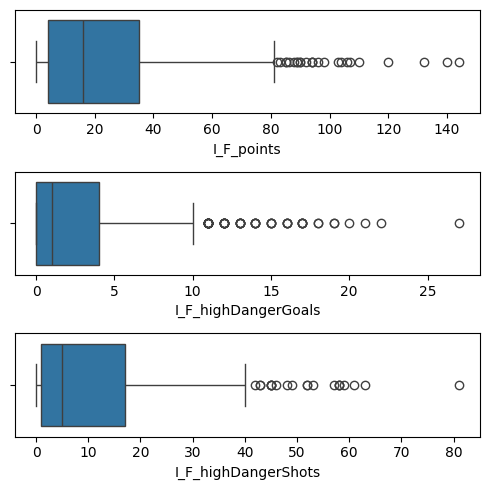

In [ ]:
fig, axs = plt.subplots(3, figsize = (5,5))
plt1 = sns.boxplot(x=df_all['I_F_points'], ax = axs[0])
plt2 = sns.boxplot(x=df_all['I_F_highDangerGoals'], ax = axs[1])
plt3 = sns.boxplot(x=df_all['I_F_highDangerShots'], ax = axs[2])
plt.tight_layout()

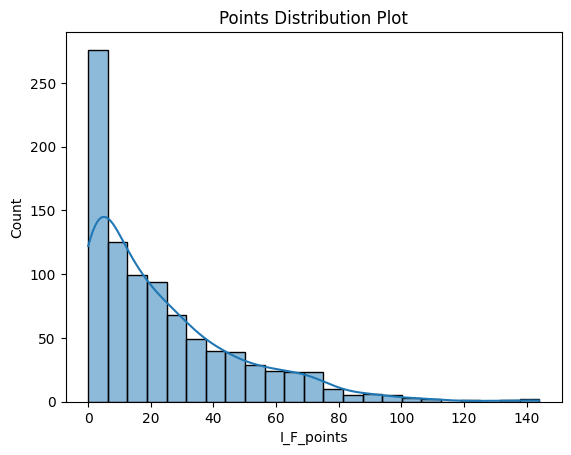

In [ ]:
# Adjusted code to use sns.histplot with KDE for density curve
plt.title('Points Distribution Plot')
sns.histplot(df_all['I_F_points'], kde=True)
plt.show()

In [ ]:
# Function to generate a unique integer hash
def hash_row(row):
    # Concatenate the values and encode them
    concatenated_string = f"{row['name']}_{row['position']}_{row['team']}"
    # Use SHA256 and take the first 8 bytes for a consistent integer hash
    return int(hashlib.sha256(concatenated_string.encode()).hexdigest()[:8], 16)

# Apply the hashing function
df_all['UniqueHash'] = df_all.apply(hash_row, axis=1)

df_stats = df_all.drop(columns=['playerId', 'season', 'name', 'team', 'position'])
df_stats.head()


,games_played,icetime,shifts,faceoffsWon,faceoffsLost,penalityMinutes,penalityMinutesDrawn,shotsBlockedByPlayer,I_F_xGoals,I_F_primaryAssists,...,I_F_lowDangerShots,I_F_mediumDangerShots,I_F_highDangerShots,I_F_lowDangerxGoals,I_F_mediumDangerxGoals,I_F_highDangerxGoals,I_F_lowDangerGoals,I_F_mediumDangerGoals,I_F_highDangerGoals,UniqueHash
1,74,76034.0,1717.0,0.0,0.0,47.0,23.0,168.0,2.71,4.0,...,66.0,5.0,2.0,1.43,0.67,0.61,0.0,0.0,0.0,4214337758
6,71,60495.0,1254.0,211.0,289.0,8.0,28.0,31.0,13.95,13.0,...,125.0,40.0,16.0,4.53,4.89,4.52,6.0,7.0,5.0,3434983266
11,81,80548.0,1859.0,618.0,558.0,38.0,34.0,57.0,20.86,15.0,...,112.0,68.0,24.0,3.78,8.99,8.09,1.0,7.0,7.0,3529290617
16,82,85591.0,1949.0,0.0,0.0,72.0,24.0,103.0,2.27,5.0,...,95.0,2.0,0.0,2.03,0.24,0.00,1.0,0.0,0.0,1514292796
21,57,33372.0,834.0,159.0,242.0,8.0,12.0,29.0,5.45,4.0,...,30.0,15.0,8.0,0.96,1.84,2.65,1.0,2.0,0.0,2919285494


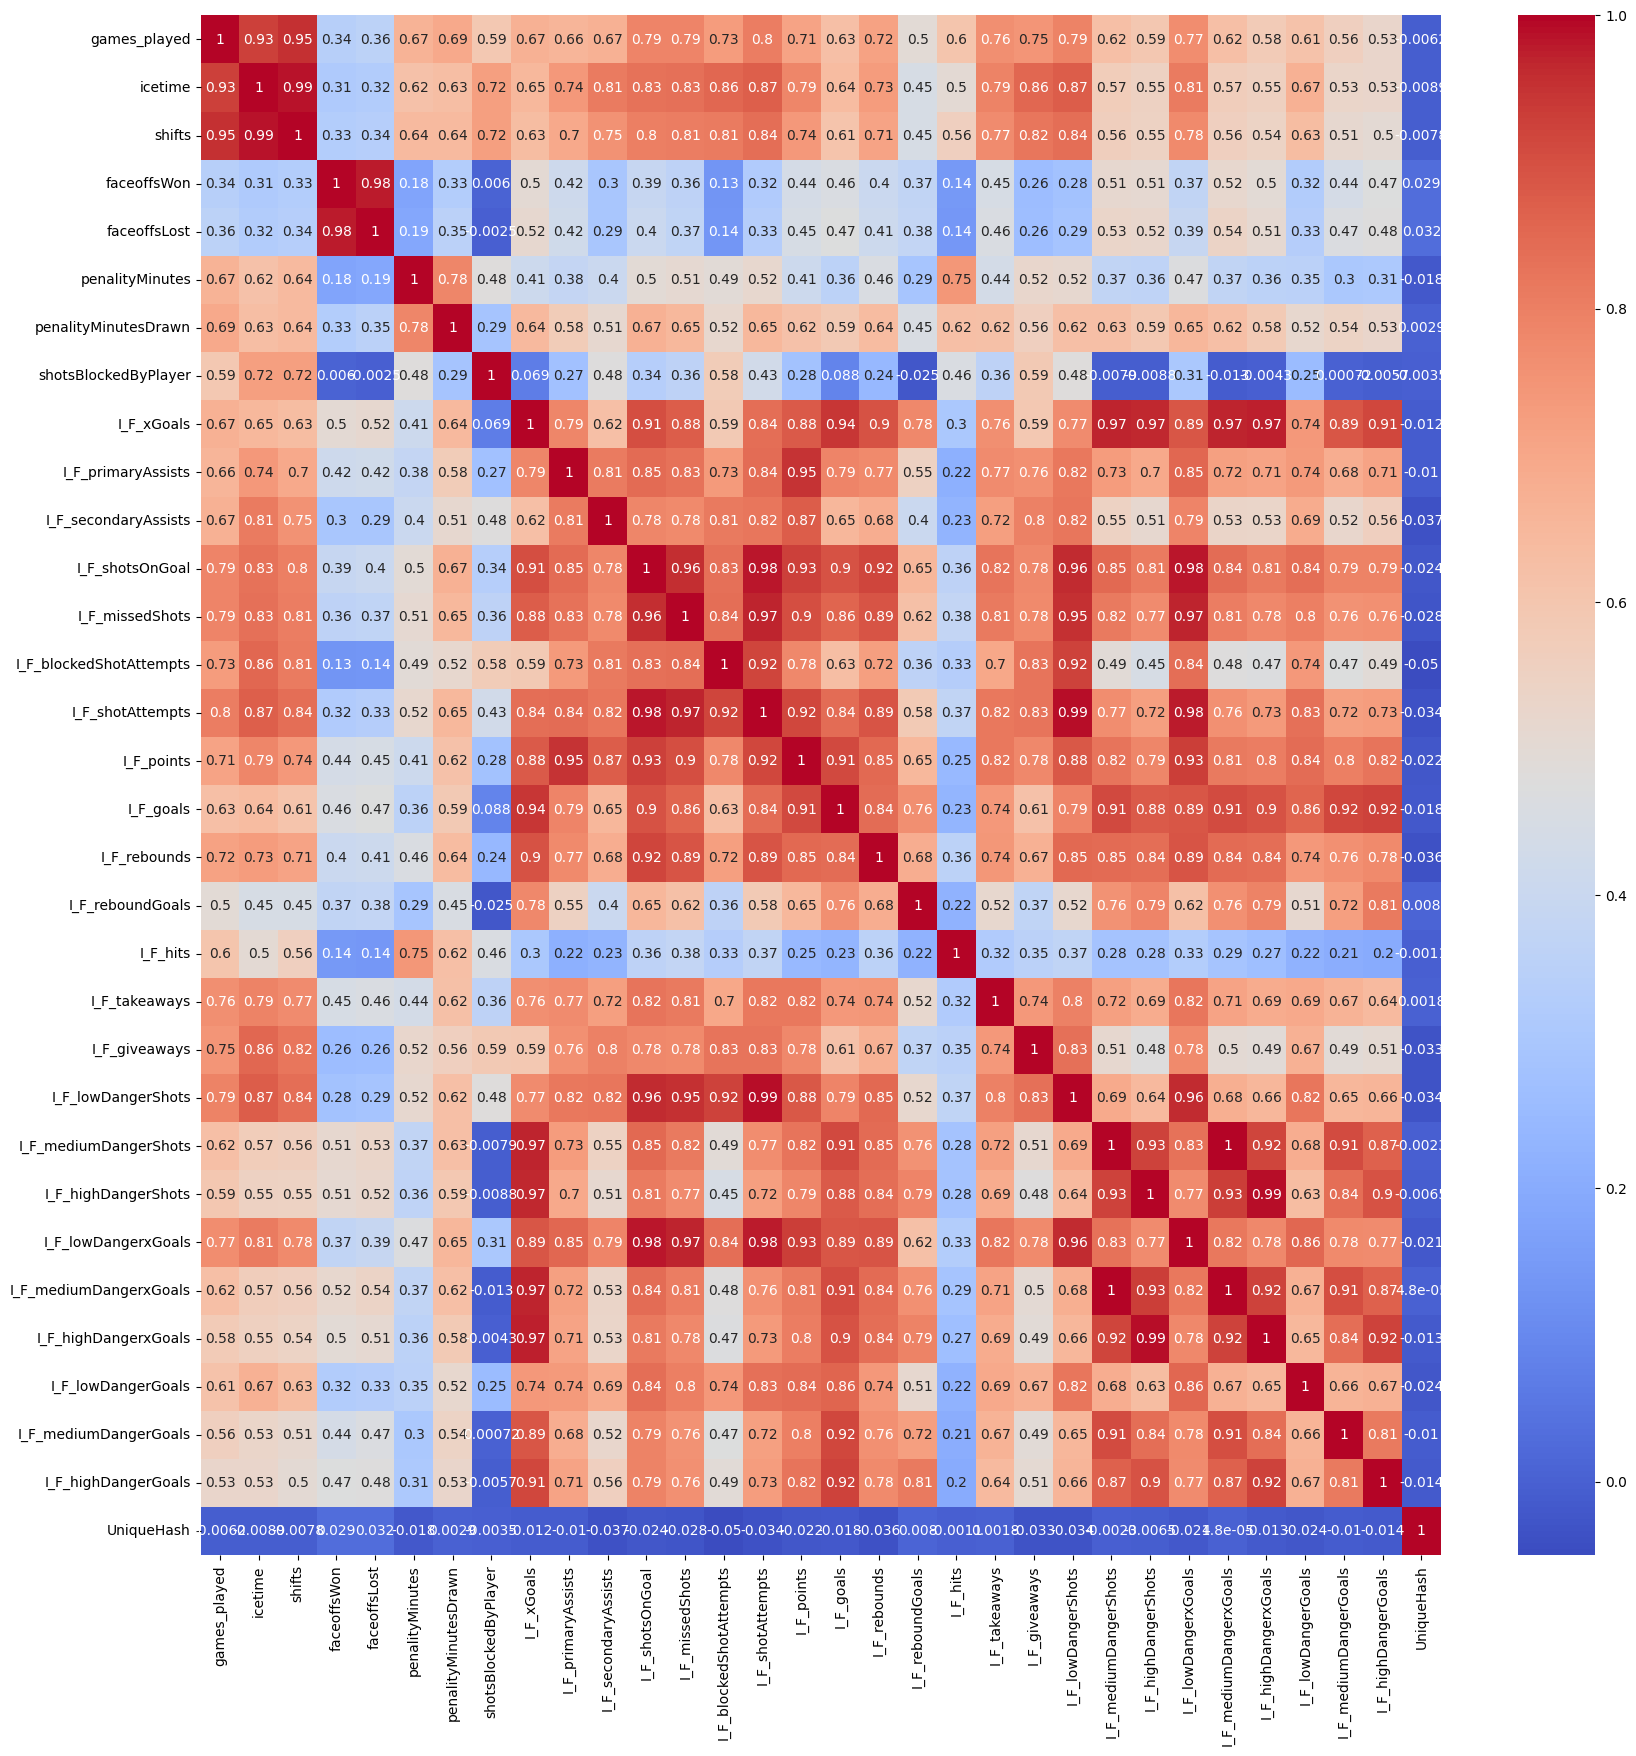

In [ ]:
corr = df_stats.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
corr['I_F_points'].sort_values(ascending=False)

,I_F_points
I_F_points,1.000000
I_F_primaryAssists,0.948145
I_F_lowDangerxGoals,0.930435
I_F_shotsOnGoal,0.928543
I_F_shotAttempts,0.916372
I_F_goals,0.912211
I_F_missedShots,0.903691
I_F_lowDangerShots,0.882445
I_F_xGoals,0.879383
I_F_secondaryAssists,0.873770


In [ ]:
df_stats = df_stats.apply(lambda row: row / row['games_glayed'] if row.name in ['UniqueHash'] else row, axis=1)

In [ ]:
predictorColumns = ['games_played', 'icetime', 'shifts',
                    'faceoffsWon', 'faceoffsLost', 'shotsBlockedByPlayer',
                    'I_F_primaryAssists', 'I_F_secondaryAssists',
                    'I_F_shotAttempts', 'penalityMinutes',
                    'I_F_goals', 'I_F_hits']


In [ ]:
# Splitting variables
X = df_stats.filter(predictorColumns)
Y = df_stats['I_F_points']

In [ ]:
X = X.div(X['games_played'], axis=0)
Y = Y.div(X['games_played'], axis=0)

X['icetimePerShift'] = X['icetime']/X['shifts']

In [ ]:
X.drop(columns=['games_played', 'icetime', 'shifts'], inplace=True)

In [ ]:
# X_norm=(X-X.mean())/X.std()
# Y_norm=(Y-Y.mean())/Y.std()

X_norm=(X-X.min())/(X.max()-X.min())
Y_norm=(Y-Y.min())/(Y.max()-Y.min())

In [ ]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y_norm, test_size=0.3, random_state=42)

In [ ]:
# Creating and training the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Predicting on the test set
y_pred = model.predict(X_test)

In [ ]:
# Extracting model metrics and details
intercept = model.intercept_
coefficients = model.coef_
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [ ]:
coefficients.shape

(10,)

In [ ]:
coefficients.flatten().shape

(10,)

In [ ]:
# Explicitly ensuring both arrays are 1-dimensional
coef_df = pd.DataFrame({
    'Feature': list(X.columns),  # Converting to list to ensure 1D
    'Coefficient': coefficients.flatten()  # Flattening to 1D if not already
})

# Display the resulting coefficients DataFrame
coef_df


,Feature,Coefficient
0,faceoffsWon,0.219186
1,faceoffsLost,-0.113257
2,shotsBlockedByPlayer,0.007393
3,I_F_primaryAssists,0.526671
4,I_F_secondaryAssists,0.279316
5,I_F_shotAttempts,0.169839
6,penalityMinutes,0.100045
7,I_F_goals,0.344104
8,I_F_hits,0.008626
9,icetimePerShift,0.059044


In [ ]:
# Display results

print(f"Intercept: {intercept:#.5f}")
print(f"Mean Squared Error: {mse:#.5f}")
print(f"R-squared: {r2:#.5f}")

print("\nCoefficients:")
for feature, coef in zip(X.columns, coefficients):
    print(f"{feature}: {coef:#.5f}")

Intercept: -0.08774
Mean Squared Error: 0.00628
R-squared: 0.78128

Coefficients:
faceoffsWon: 0.21919
faceoffsLost: -0.11326
shotsBlockedByPlayer: 0.00739
I_F_primaryAssists: 0.52667
I_F_secondaryAssists: 0.27932
I_F_shotAttempts: 0.16984
penalityMinutes: 0.10004
I_F_goals: 0.34410
I_F_hits: 0.00863
icetimePerShift: 0.05904


In [ ]:
#Actual value and the predicted value
mlr_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': y_pred})
mlr_diff

,Actual value,Predicted value
1616,0.291667,0.238806
4306,0.131944,0.271357
151,0.027778,0.050181
4186,0.090278,0.066965
1471,0.201389,0.164854
...,...,...
2756,0.131944,0.141455
2021,0.361111,0.309688
1546,0.083333,0.079725
666,0.069444,0.052173


In [ ]:
mlr_diff.describe()

,Actual value,Predicted value
count,278.000000,278.000000
mean,0.165418,0.166551
std,0.169771,0.156021
min,0.000000,-0.069142
25%,0.027778,0.062585
50%,0.125000,0.136874
75%,0.243056,0.238701
max,0.916667,0.844198
